# lstm_example

### Use a basic LSTM to regress data and predict future prices for the Commodity ETF USO.

####  This project is adapted from the tutorial by Robert Guthrie at: 

http://seba1511.net/tutorials/beginner/nlp/sequence_models_tutorial.html#sphx-glr-beginner-nlp-sequence-models-tutorial-py


In [1]:
%matplotlib inline

In [2]:

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing
import warnings
warnings.filterwarnings('ignore')

In [3]:
# make batches from 2d matrix m
def make_batches(m,ss=20,row_len=None):
    rl = m.shape[1] if row_len is None else row_len
    x = [m[i:(int((len(m)-i)/ss)*ss)+i].reshape(-1,ss,rl) for i in range(len(m)-ss)]
    xx = []
    for i in range(len(x)):
        xx.extend(x[i].reshape(-1))
    input_batches = np.array(xx).reshape(-1,ss,rl)
    return input_batches
    

In [4]:
# Here we define our model as a class
class LSTM(nn.Module):

    def __init__(self, input_dim, hidden_dim,hidden = None, output_dim=1,
                    num_layers=2):
        super(LSTM, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.hidden = hidden
        # Define the LSTM layer
        self.lstm = nn.LSTM(self.input_dim, self.hidden_dim, self.num_layers)

        # Define the output layer
        self.linear = nn.Linear(self.hidden_dim, output_dim)

    def init_hidden(self,batch_size):
        # This is what we'll initialise our hidden state as
        return (torch.zeros(self.num_layers, batch_size, self.hidden_dim),
                torch.zeros(self.num_layers, batch_size, self.hidden_dim))

    def forward(self, input):
        in_var = torch.Tensor(input)
        batch_size = in_var.size(1)
        if self.hidden is None:
          self.hidden = self.init_hidden(batch_size)
        lstm_out, self.hidden = self.lstm(in_var,(self.hidden[0].detach(),self.hidden[1].detach()))
        # Only take the output from the final timetep
        # Can pass on the entirety of lstm_out to the next layer if it is a seq2seq prediction
        y_pred = self.linear(lstm_out[-1].view(batch_size, -1))
        return y_pred.view(-1)



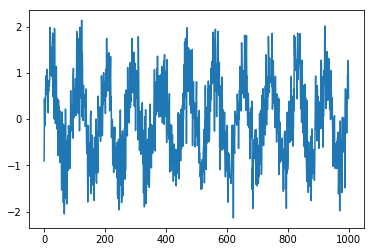

In [5]:
noise_level = .5
cycles = 300
x_vals = np.linspace(0,360*cycles,360*cycles/4 + 1)
y_vals = np.sin(x_vals*np.pi/180)
y_vals = y_vals + np.random.randn(len(y_vals)) * noise_level
# df = pd.DataFrame({'x_vals':x_vals,'close':y_vals})
# df.iloc[:1000].close.plot.line()
plt.plot(y_vals[:1000])

In [6]:
seq_len = 19
total_batches = int(len(y_vals)/(seq_len+1))
y_vals_2d = y_vals[0:(total_batches*(seq_len+1))].reshape(total_batches,seq_len+1)
x_in = y_vals_2d.reshape(total_batches,seq_len+1,1)
x_in = np.transpose(x_in,(1,0,2))
x_in = x_in[:seq_len,:,:]
y_in = y_vals_2d[:,-1].reshape(-1)
tests = 50
train = total_batches - tests
X_train = x_in[:,:train,:]
y_train = y_in[:train]
X_test = x_in[:,train:,:]
y_test = y_in[train:]

X_train.shape,y_train.shape,X_test.shape,y_test.shape


((19, 1300, 1), (1300,), (19, 50, 1), (50,))

In [7]:
torch.Tensor(X_train).size()

torch.Size([19, 1300, 1])

In [8]:
lstm_input_size = X_train.shape[2]
h1 = 64
output_dim = 1
num_layers = 1
model = LSTM(lstm_input_size, h1,  output_dim=output_dim, num_layers=num_layers)

num_epochs = 500
learning_rate  =.02
loss_fn = torch.nn.MSELoss(size_average=False)

optimiser = torch.optim.Adam(model.parameters(), lr=learning_rate)

#####################
# Train model
#####################

hist = np.zeros(num_epochs)
yt = torch.tensor(y_train,dtype=torch.float32)
for t in range(num_epochs):
    # Clear stored gradient
#     model.zero_grad()
        
    # Forward pass
    y_pred = model(X_train)
    loss = loss_fn(y_pred, yt)
    if t % 20 == 0:
        print("Epoch ", t, "MSE: ", loss.item())
    hist[t] = loss.item()

    # Zero out gradient, else they will accumulate between epochs
    optimiser.zero_grad()

    # Backward pass
    loss.backward()

    # Update parameters
    optimiser.step()


Epoch  0 MSE:  949.3350219726562
Epoch  20 MSE:  486.4766540527344
Epoch  40 MSE:  394.2547302246094
Epoch  60 MSE:  387.166015625
Epoch  80 MSE:  381.189208984375
Epoch  100 MSE:  359.9209289550781
Epoch  120 MSE:  339.68408203125
Epoch  140 MSE:  339.6602478027344
Epoch  160 MSE:  331.43212890625
Epoch  180 MSE:  318.31842041015625
Epoch  200 MSE:  312.08233642578125
Epoch  220 MSE:  323.024658203125
Epoch  240 MSE:  294.7080383300781
Epoch  260 MSE:  293.65582275390625
Epoch  280 MSE:  282.2705993652344
Epoch  300 MSE:  275.7148132324219
Epoch  320 MSE:  231.4066162109375
Epoch  340 MSE:  192.57313537597656
Epoch  360 MSE:  154.0715789794922
Epoch  380 MSE:  150.17459106445312
Epoch  400 MSE:  93.07353973388672
Epoch  420 MSE:  56.6368408203125
Epoch  440 MSE:  39.62296676635742
Epoch  460 MSE:  40.20351028442383
Epoch  480 MSE:  21.668079376220703


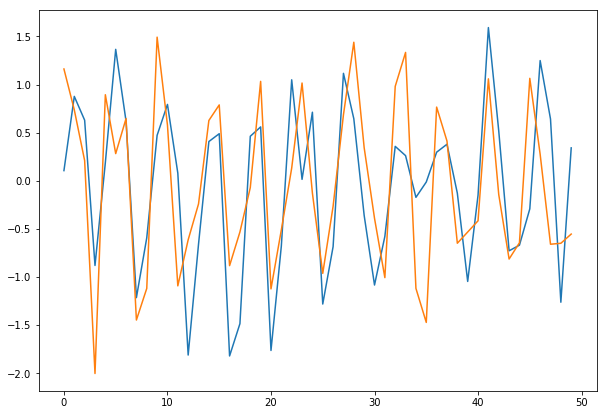

In [12]:
# you should see just one line
model.hidden = None
y_t = model(X_test).data.numpy()
fig= plt.figure(figsize=(10,7))
plt.plot(y_t.round(5))
plt.plot(y_test.round(5))

In [13]:
md_folder = '/Users/bperlman1/Dropbox/market_data'
uso_path = f'{md_folder}/stocks/uso.csv'
df_uso = pd.read_csv(uso_path)
df_uso['year'] = df_uso.timestamp.str.slice(0,4).astype(int)
df_uso['month'] = df_uso.timestamp.str.slice(5,7).astype(int)
df_uso['day'] = df_uso.timestamp.str.slice(8,10).astype(int)
df_uso['hour'] = df_uso.timestamp.str.slice(11,13).astype(int)
df_uso['minute'] = df_uso.timestamp.str.slice(14,16).astype(int)


In [14]:
df_uso.columns.values

array(['close', 'high', 'low', 'open', 'symbol', 'timestamp',
       'tradingDay', 'volume', 'year', 'month', 'day', 'hour', 'minute'],
      dtype=object)

In [15]:
df_uso_2018 = df_uso[df_uso.tradingDay.str.contains('2018')]
df_uso_2018 = df_uso_2018[(df_uso_2018.hour>=7) & (df_uso_2018.hour<=17)]
# for c in ['close','open','high','low','volume']:
#     df_uso_2018[c] = df_uso_2018[c].pct_change()
# df_uso_2018 = df_uso_2018.iloc[1:]

In [16]:
def getm(dfgb):
    print(dfgb[['year','month','day']].iloc[0].as_matrix())
    return make_batches(dfgb.as_matrix())
df2018 = df_uso_2018[['close','open','high','low','volume','year','month','day','hour','minute']]
df_matrices = df2018.groupby(['year','month','day']).apply(getm)

[2018    1    2]
[2018    1    3]
[2018    1    4]
[2018    1    5]
[2018    1    8]
[2018    1    9]
[2018    1   10]
[2018    1   11]
[2018    1   12]
[2018    1   16]
[2018    1   17]
[2018    1   18]
[2018    1   19]
[2018    1   22]
[2018    1   23]
[2018    1   24]
[2018    1   25]
[2018    1   26]
[2018    1   29]
[2018    1   30]
[2018    1   31]
[2018    2    1]
[2018    2    2]
[2018    2    5]
[2018    2    6]
[2018    2    7]
[2018    2    8]
[2018    2    9]
[2018    2   12]
[2018    2   13]
[2018    2   14]
[2018    2   15]
[2018    2   16]
[2018    2   20]
[2018    2   21]
[2018    2   22]
[2018    2   23]
[2018    2   26]
[2018    2   27]
[2018    2   28]
[2018    3    1]
[2018    3    2]
[2018    3    5]
[2018    3    6]
[2018    3    7]
[2018    3    8]
[2018    3    9]
[2018    3   12]
[2018    3   13]
[2018    3   14]
[2018    3   15]
[2018    3   16]
[2018    3   19]
[2018    3   20]
[2018    3   21]
[2018    3   22]
[2018    3   23]
[2018    3   26]
[2018    3   2

In [17]:
g = df2018.groupby(['year','month','day']).get_group((2018, 1, 2))
g.shape,make_batches(g.as_matrix()).shape

((388, 10), (3590, 20, 10))

In [18]:
mm = []
for mmm in df_matrices.values:
    mm.extend(mmm)
mm = np.array(mm)
mm.shape

(854970, 20, 10)

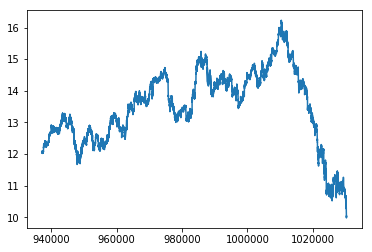

In [19]:
plt.plot(df_uso_2018.close)

In [20]:
m = df_uso_2018[['close','open','high','low','volume','month','day','hour','minute']].as_matrix()


In [21]:
# define sequence size
ss = 20

In [22]:

inp_len = m.shape[1]
x = [m[i:(int((len(m)-i)/ss)*ss)+i].reshape(-1,ss,inp_len) for i in range(len(m)-ss)]
xx = []
for i in range(len(x)):
    if i % 5000 == 0:
        print(i)
        xx.extend(x[i].reshape(-1))
input_batches = np.array(xx).reshape(-1,ss,inp_len)
use_pct_change = False
if use_pct_change:
    a = input_batches[:,1:,:5]/input_batches[:,0:-1,:5] - 1
    input_batches = np.concatenate((a,input_batches[:,1:,5:]),axis=2)
input_batches.shape

0
5000
10000
15000
20000
25000
30000
35000
40000
45000
50000
55000
60000
65000
70000
75000
80000
85000
90000


(45790, 20, 9)

In [23]:
input_batches = mm.copy()

In [24]:
feature_to_predict = 0
use_all_features=True
if use_all_features:
    X_vals = input_batches[:,:-1,:].transpose(1,0,2) # use all features
else:
    X_vals = input_batches[:,:-1,:1].transpose(1,0,2) # use only the first (like the close)
y_vals = input_batches[:,-1,feature_to_predict]

In [25]:
X_vals.shape,y_vals.shape

((19, 854970, 10), (854970,))

In [26]:
train_size = 100000
test_size = 100
X_train = X_vals[:,:train_size,:]
y_train = y_vals[:train_size]
X_test = X_vals[:,train_size:(train_size+test_size),:]
y_test = y_vals[train_size:(train_size+test_size)]
X_train.shape,y_train.shape,X_test.shape,y_test.shape

((19, 100000, 10), (100000,), (19, 100, 10), (100,))

In [ ]:

lstm_input_size = X_train.shape[2]
h1 = 64
output_dim = 1
num_layers = 1
model = LSTM(lstm_input_size, h1,  output_dim=output_dim, num_layers=num_layers)

num_epochs = 150
init_lr  = .01
min_lr = .01
loss_fn = torch.nn.MSELoss(size_average=False)

optimiser = torch.optim.Adam(model.parameters(), lr=init_lr)

#####################
# Train model
#####################

hist = np.zeros(num_epochs)
# yt = torch.tensor(y_train,dtype=torch.float32)
yt = Variable(torch.from_numpy(y_train).type(torch.FloatTensor))

lowest_loss = np.finfo('d').max

for t in range(num_epochs):
    # Clear stored gradient
#     model.zero_grad()
        
    # Forward pass
    y_pred = model(X_train)
    
    loss = loss_fn(y_pred, yt)
    if t % 1 == 0:
        print("Epoch ", t, "MSE: ", loss.item())
    hist[t] = loss.item()

    # Zero out gradient, else they will accumulate between epochs
    optimiser.zero_grad()

    # Backward pass
    loss.backward()

    # Update parameters
    optimiser.step()
        
    if loss.item() < lowest_loss:
        lowest_loss = loss.item()
#     if t % 5 == 0 and t > 0:
#         for param_group in optimiser.param_groups:
#             if param_group['lr'] > min_lr:
#                 param_group['lr'] = param_group['lr'] * 0.9
    


Epoch  0 MSE:  16724156.0
Epoch  1 MSE:  15607144.0
Epoch  2 MSE:  14851551.0
Epoch  3 MSE:  14291066.0
Epoch  4 MSE:  13777349.0
Epoch  5 MSE:  13263957.0
Epoch  6 MSE:  12775790.0


In [ ]:
# y_pred.size()
yt.size()

In [ ]:
beg_seq = 1
seq_len = 4
num_seq = 200000

seqs = np.arange(beg_seq,beg_seq+beg_seq*seq_len*num_seq).reshape(-1,l)
x_in = a[:,:-1]
y_in = a[:,-1:]

In [ ]:
x_in.shape,y_in.shape

In [ ]:
yearly_std = .2
daily_std = .2 / 252**.5
y_init = 100
steps = 100
pct_changes = np.random.choice([-1,1],size=(steps)) * np.random.randn(steps)* daily_std
vals = np.concatenate(([y_init],np.zeros(steps-1)))
# 100, i-1 * (1+c1),i-1 * (1+c2),i-1 * (1+c3)

# 100, 
# 100 * (1+c1), 
# (100 * (1+c1)*(1+c2)), 
# (100 * (1+c1)*(1+c2))* (1+c3)
p=1
plt.plot([y_init * np.prod([(1+pct_changes[i-p:i])]) for i in range(p,steps)])


In [ ]:
X_vals = input_batches[:,:-1,:1].transpose(1,0,2)
y_vals = input_batches[:,-1,0]

In [ ]:
x2 = make_batches(m)
x2.shape